# Wine quality analysis - Machine Learning - Logistic Model


Datasource: https://archive.ics.uci.edu/ml/datasets/wine+quality

## Columns description


Column Position | Atrribute Name | Definition 
 --- | --- | --- 
1 | fixed acidity | most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
2 | volatile acidity | the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
3 | citric acid | found in small quantities, citric acid can add 'freshness' and flavor to wines
4 | residual sugar | the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet
5 | chlorides | the amount of salt in the wine
6 | free sulfur dioxidet | he free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine
7 | total sulfur dioxide | amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine
8 | density | the density of water is close to that of water depending on the percent alcohol and sugar content
9 | pH | describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale
10 | sulphates | a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant
11 | alcohol | the percent alcohol content of the wine
12 | quality | output variable (based on sensory data, score between 0 and 10)
13 | good | binary evaluation 1 - good , 0 - bad
14 | color | wine type red or white

# Import libraries 

In [4]:
# this may need to be changed to run on non mac computers

import findspark
import pyspark
#spark = pyspark.SparkContext(appName="winequality")
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("winequality").getOrCreate()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
import numpy as np

#import stats libraries 
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from pyspark.sql import SparkSession

In [6]:
df = spark.read.csv("winequality.csv",header=True,inferSchema=True)

In [7]:
#df.show(n=2, truncate=False, vertical=True)
df.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red


In [8]:
#Create DF for red and white wine
df_red = df.filter(df.color =='red')
df_white = df.filter(df.color =='white')

In [9]:
#create lists of categorical and numberical columns

cat = [item[0] for item in df.dtypes if item[1].startswith('string') ]
num = [item for item in df.columns if item not in cat]
print(cat)
print(num)

['color']
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'good']


# Data preparation for machine learning

In [28]:
#Import libraries
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import sklearn 
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
#create input vector
features_column = num[0:-2]

assembler = (VectorAssembler()
  .setInputCols(features_column)
  .setOutputCol("features"))

finalPrep = assembler.transform(df)
#finalPrep.show(n=1, truncate=False, vertical=True)
finalPrep.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color,features
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red,"[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978..."
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,red,"[7.8, 0.88, 0.0, 2.6, 0.098, 25.0, 67.0, 0.996..."
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,red,"[7.8, 0.76, 0.04, 2.3, 0.092, 15.0, 54.0, 0.99..."
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,red,"[11.2, 0.28, 0.56, 1.9, 0.075, 17.0, 60.0, 0.9..."
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red,"[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978..."


In [12]:
#split in training and testing datasets
training, test = finalPrep.randomSplit([0.7, 0.3])
# Going to cache the data  
training.cache()
test.cache()
print(training.count())
print(test.count())

4565
1932


### Data preparation for machine learning - Red only

In [13]:
#create input vector
features_column = num[0:-2]

assembler_red = (VectorAssembler()
  .setInputCols(features_column)
  .setOutputCol("features"))

finalPrep_red = assembler_red.transform(df_red)
#finalPrep_red.show(n=1, truncate=False, vertical=True)
finalPrep_red.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color,features
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red,"[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978..."
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,red,"[7.8, 0.88, 0.0, 2.6, 0.098, 25.0, 67.0, 0.996..."
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,red,"[7.8, 0.76, 0.04, 2.3, 0.092, 15.0, 54.0, 0.99..."
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,red,"[11.2, 0.28, 0.56, 1.9, 0.075, 17.0, 60.0, 0.9..."
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red,"[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978..."


In [14]:
#split in training and testing datasets
training_red, test_red = finalPrep_red.randomSplit([0.7, 0.3])
# Going to cache the data  
training_red.cache()
test_red.cache()
print(training_red.count())
print(test_red.count())

1122
477


### Data preparation for machine learning - White only

In [15]:
#create input vector
features_column = num[0:-2]

assembler_white = (VectorAssembler()
  .setInputCols(features_column)
  .setOutputCol("features"))

finalPrep_white = assembler_red.transform(df_white)
#finalPrep_red.show(n=1, truncate=False, vertical=True)
finalPrep_white.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color,features
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,white,"[7.0, 0.27, 0.36, 20.7, 0.045, 45.0, 170.0, 1...."
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,white,"[6.3, 0.3, 0.34, 1.6, 0.049, 14.0, 132.0, 0.99..."
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,white,"[8.1, 0.28, 0.4, 6.9, 0.05, 30.0, 97.0, 0.9951..."
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,white,"[7.2, 0.23, 0.32, 8.5, 0.058, 47.0, 186.0, 0.9..."
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,white,"[7.2, 0.23, 0.32, 8.5, 0.058, 47.0, 186.0, 0.9..."


In [16]:
#split in training and testing datasets
training_white, test_white = finalPrep_white.randomSplit([0.7, 0.3])
# Going to cache the data  
training_white.cache()
test_white.cache()
print(training_white.count())
print(test_white.count())

3464
1434


### Encode Wine type and include in the model

In [17]:
cat

['color']

In [18]:
#convert cat data into INT

#define a list of stages in your pipeline. The string indexer will be one stage
stages = []

#iterate through all categorical values
for categoricalCol in cat:
    #create a string indexer for those categorical values and assign a new name including the word 'Index'
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')

    #append the string Indexer to our list of stages
    stages += [stringIndexer]

#Create the pipeline. Assign the satges list to the pipeline key word stages
pipeline = Pipeline(stages = stages)
#fit the pipeline to our dataframe
pipelineModel = pipeline.fit(df)
#transform the dataframe
df_enc= pipelineModel.transform(df)

In [19]:
df_enc.show(n=2, truncate=False, vertical=True)

-RECORD 0----------------------
 fixed acidity        | 7.4    
 volatile acidity     | 0.7    
 citric acid          | 0.0    
 residual sugar       | 1.9    
 chlorides            | 0.076  
 free sulfur dioxide  | 11.0   
 total sulfur dioxide | 34.0   
 density              | 0.9978 
 pH                   | 3.51   
 sulphates            | 0.56   
 alcohol              | 9.4    
 quality              | 5      
 good                 | 0      
 color                | red    
 colorIndex           | 1.0    
-RECORD 1----------------------
 fixed acidity        | 7.8    
 volatile acidity     | 0.88   
 citric acid          | 0.0    
 residual sugar       | 2.6    
 chlorides            | 0.098  
 free sulfur dioxide  | 25.0   
 total sulfur dioxide | 67.0   
 density              | 0.9968 
 pH                   | 3.2    
 sulphates            | 0.68   
 alcohol              | 9.8    
 quality              | 5      
 good                 | 0      
 color                | red    
 colorIn

In [20]:
num_enc = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'colorIndex']
num_enc

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'colorIndex']

In [21]:
#create input vector
features_column = num_enc

assembler = (VectorAssembler()
  .setInputCols(features_column)
  .setOutputCol("features"))

finalPrep = assembler.transform(df_enc)
finalPrep.show(n=1, truncate=False, vertical=True)

-RECORD 0--------------------------------------------------------------------------
 fixed acidity        | 7.4                                                        
 volatile acidity     | 0.7                                                        
 citric acid          | 0.0                                                        
 residual sugar       | 1.9                                                        
 chlorides            | 0.076                                                      
 free sulfur dioxide  | 11.0                                                       
 total sulfur dioxide | 34.0                                                       
 density              | 0.9978                                                     
 pH                   | 3.51                                                       
 sulphates            | 0.56                                                       
 alcohol              | 9.4                                                 

In [22]:
#split in training and testing datasets
training_enc, test_enc = finalPrep.randomSplit([0.7, 0.3])
# Going to cache the data  
training_enc.cache()
test_enc.cache()
print(training_enc.count())
print(test_enc.count())

4571
1926


# Logistic Regression

In [23]:
from pyspark.ml.classification import LogisticRegression
print(LogisticRegression().explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal wi

In [34]:
def LogisticClassifer(training, test):
    model = (LogisticRegression()
      .setLabelCol("good")
      .setFeaturesCol("features"))
    paramGrid = (ParamGridBuilder()
      .addGrid(model.maxIter, [100])
      .addGrid(model.threshold, [0.35,0.5,0.65])
      .build())

    stages = [model] 
    pipeline = Pipeline().setStages(stages)
    
    cv = (CrossValidator() # you can feel free to change the number of folds used in cross validation as well
      .setEstimator(pipeline) # the estimator can also just be an individual model rather than a pipeline
      .setEstimatorParamMaps(paramGrid)
      .setEvaluator(BinaryClassificationEvaluator().setLabelCol("good")))
    
    pipelineFitted = cv.fit(training)
    
    print("The Best Parameters:\n--------------------")
    print(pipelineFitted.bestModel.stages[0])      
    pipelineFitted.bestModel.stages[0].extractParamMap()
    
    test_predict = pipelineFitted.bestModel.transform(test).selectExpr("double(round(prediction)) as prediction","double(round(good)) as good")
    display(test_predict.show(3))
    
    return test_predict

In [25]:
def ConfMatrix(test_predict):
        #collect prediction and true value
    y_true = test_predict.select(['good']).collect()
    y_pred = test_predict.select(['prediction']).collect()

    #classification report
    print(classification_report(y_true, y_pred))
    
    #confusion matrix 

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

In [29]:
def Evaluation(test_predict):
    acc = test_predict.selectExpr("prediction", "good",
                        """
                        CASE prediction = good
                        WHEN true then 1
                        ELSE 0
                        END as equal
                        """)
        
    print(acc.selectExpr("sum(equal)/sum(1)").show())

    # Another way to evaluate error
    evaluator = MulticlassClassificationEvaluator(labelCol="good", predictionCol="prediction", metricName="accuracy")
    
    accuracy = evaluator.evaluate(test_predict)
    print("Test Error = %g" % (1.0 - accuracy))
    
    ConfMatrix(test_predict)

### Logistic Regression - all wine

The Best Parameters:
--------------------
LogisticRegressionModel: uid=LogisticRegression_2c5c3dac3e73, numClasses=2, numFeatures=12
+----------+----+
|prediction|good|
+----------+----+
|       1.0| 1.0|
|       1.0| 1.0|
|       0.0| 1.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8037383177570093|
+---------------------+

None
Test Error = 0.196262
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88      1555
         1.0       0.49      0.49      0.49       371

    accuracy                           0.80      1926
   macro avg       0.68      0.68      0.68      1926
weighted avg       0.80      0.80      0.80      1926



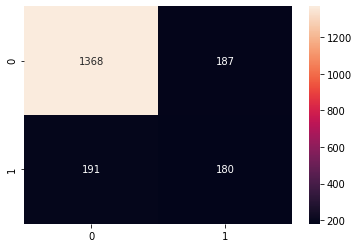

In [30]:
test_predict = LogisticClassifer(training_enc, test_enc)
Evaluation(test_predict)

### Logistic Regression - red wine

The Best Parameters:
--------------------
LogisticRegressionModel: uid=LogisticRegression_fed0de997b7e, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 0.0|
|       0.0| 0.0|
|       1.0| 1.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8679245283018868|
+---------------------+

None
Test Error = 0.132075
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92       418
         1.0       0.47      0.51      0.49        59

    accuracy                           0.87       477
   macro avg       0.70      0.71      0.71       477
weighted avg       0.87      0.87      0.87       477



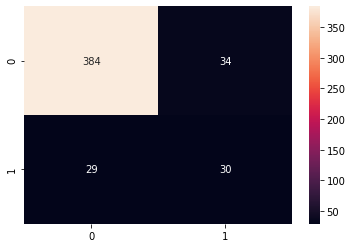

In [31]:
test_predict = LogisticClassifer(training_red, test_red)
Evaluation(test_predict)

### Logistic Regression - white only

The Best Parameters:
--------------------
LogisticRegressionModel: uid=LogisticRegression_9e283d14dae7, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 0.0|
|       0.0| 0.0|
|       1.0| 0.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.7838214783821479|
+---------------------+

None
Test Error = 0.216179
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86      1138
         1.0       0.48      0.52      0.50       296

    accuracy                           0.78      1434
   macro avg       0.68      0.69      0.68      1434
weighted avg       0.79      0.78      0.79      1434



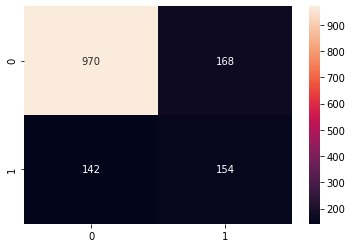

In [32]:
test_predict = LogisticClassifer(training_white, test_white)
Evaluation(test_predict)

# Logistic Regression - Multi-Class Classification

In [43]:
def MC_LRClassifer(training, test):
    model = (LogisticRegression()
      .setLabelCol("quality")
      .setFeaturesCol("features"))
    
    paramGrid = (ParamGridBuilder()
      .addGrid(model.maxIter, [100])
      .addGrid(model.threshold, [0.35,0.5,0.65])
      .build())

    stages = [model]
    pipeline = Pipeline().setStages(stages)
    
    cv = (CrossValidator() # you can feel free to change the number of folds used in cross validation as well
      .setEstimator(pipeline) # the estimator can also just be an individual model rather than a pipeline
      .setEstimatorParamMaps(paramGrid)
      .setEvaluator(BinaryClassificationEvaluator().setLabelCol("quality")))
    
    pipelineFitted = cv.fit(training)
    
    print("The Best Parameters:\n--------------------")
    print(pipelineFitted.bestModel.stages[0])      
    pipelineFitted.bestModel.stages[0].extractParamMap()
    
    test_predict = pipelineFitted.bestModel.transform(test).selectExpr("double(round(prediction)) as prediction","double(round(quality)) as quality")
    display(test_predict.show(3))
    
    return test_predict

In [37]:
def MC_ConfMatrix(test_predict):
        #collect prediction and true value
    y_true = test_predict.select(['quality']).collect()
    y_pred = test_predict.select(['prediction']).collect()

    #classification report
    print(classification_report(y_true, y_pred))
    
    #confusion matrix 

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

In [38]:
def MC_Evaluation(test_predict):
    acc = test_predict.selectExpr("prediction", "quality",
                        """
                        CASE prediction = quality
                        WHEN true then 1
                        ELSE 0
                        END as equal
                        """)
        
    print(acc.selectExpr("sum(equal)/sum(1)").show())

    # Another way to evaluate error
    evaluator = MulticlassClassificationEvaluator(labelCol="quality", predictionCol="prediction", metricName="accuracy")
    
    accuracy = evaluator.evaluate(test_predict)
    print("Test Error = %g" % (1.0 - accuracy))
    
    MC_ConfMatrix(test_predict)

### Logistic Regression - Multi-Class Classification - All wine

The Best Parameters:
--------------------
LogisticRegressionModel: uid=LogisticRegression_c55dc02e7053, numClasses=10, numFeatures=12
+----------+-------+
|prediction|quality|
+----------+-------+
|       7.0|    7.0|
|       7.0|    8.0|
|       6.0|    7.0|
+----------+-------+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.5441329179646937|
+---------------------+

None
Test Error = 0.455867
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         6
         4.0       0.00      0.00      0.00        73
         5.0       0.58      0.61      0.59       602
         6.0       0.55      0.68      0.61       874
         7.0       0.41      0.30      0.34       311
         8.0       0.00      0.00      0.00        60

    accuracy                           0.54      1926
   macro avg       0.26      0.26      0.26      1926
weighted avg       0.50      0.54      0.52      1926



/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


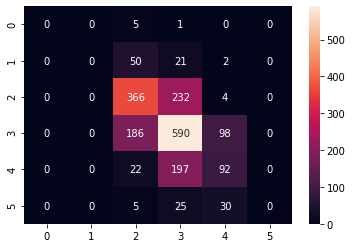

In [44]:
test_predict = MC_LRClassifer(training_enc, test_enc)
MC_Evaluation(test_predict)

### Logistic Regression - Multi-Class Classification - Red wine

The Best Parameters:
--------------------
LogisticRegressionModel: uid=LogisticRegression_044b10cbb61a, numClasses=9, numFeatures=11
+----------+-------+
|prediction|quality|
+----------+-------+
|       5.0|    4.0|
|       5.0|    5.0|
|       6.0|    7.0|
+----------+-------+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.5932914046121593|
+---------------------+

None
Test Error = 0.406709
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00      0.00        17
         5.0       0.66      0.74      0.70       215
         6.0       0.52      0.59      0.55       183
         7.0       0.55      0.29      0.38        55
         8.0       0.00      0.00      0.00         4

    accuracy                           0.59       477
   macro avg       0.29      0.27      0.27       477
weighted avg       0.56      0.59      0.57       477



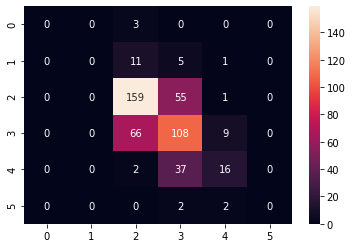

In [45]:
test_predict = MC_LRClassifer(training_red, test_red)
MC_Evaluation(test_predict)

### Logistic Regression - Multi-Class Classification - Wgite wine

The Best Parameters:
--------------------
LogisticRegressionModel: uid=LogisticRegression_b7fd1f555793, numClasses=10, numFeatures=11
+----------+-------+
|prediction|quality|
+----------+-------+
|       5.0|    5.0|
|       6.0|    5.0|
|       7.0|    5.0|
+----------+-------+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.5209205020920502|
+---------------------+

None
Test Error = 0.479079
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         6
         4.0       0.00      0.00      0.00        48
         5.0       0.51      0.51      0.51       406
         6.0       0.53      0.73      0.62       678
         7.0       0.44      0.19      0.27       253
         8.0       0.00      0.00      0.00        42
         9.0       0.00      0.00      0.00         1

    accuracy                           0.52      1434
   macro avg       0.21      0.20      0.20      1434
weighted avg       0.48      0.52      0.48      1434



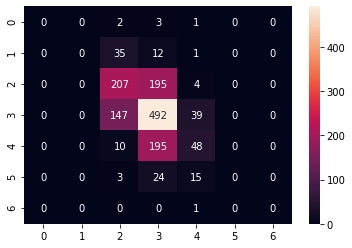

In [46]:
test_predict = MC_LRClassifer(training_white, test_white)
MC_Evaluation(test_predict)